In [13]:
import seaborn as sns
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator
import math
from scipy.stats import skew

working_dir = "./"
rna_004_1 = "../Exemplar_Data/identity_statistics/07_27_23_RNA004_GM12878_polyA_RNA_sup_8mods_polyA.GRCh38.sorted.calmd.filtered.chr2_112157000_114000000_read_stats.txt"
rna_004_091 = "../Exemplar_Data/identity_statistics/07_27_23_RNA004_GM12878_polyA_RNA.dorado_0.8.1_sup.moves.psi.GRCh38.calmd.filtered.chr2_112157000_114000000_read_stats.txt"
rna_002_2021 = "../Exemplar_Data/identity_statistics/nbt_data_6.3.2_hac.pass.NoU.hg38.sorted.calmd.filtered.chr2_112157000_114000000_read_stats.txt"
rna_002_2019 = "../Exemplar_Data/identity_statistics/NA12878-DirectRNA.pass.dedup.NoU.fastq.hg38.minimap2.sorted.calmd.filtered.chr2_112157000_114000000_read_stats.txt"

rna004_df = pd.read_csv(rna_004_091, sep='\t')
rna004_df["Align_Length"] = rna004_df["Align_Length"]

rna002_df = pd.read_csv(rna_002_2021, sep = "\t")
rna002_df["Align_Length"] = rna002_df["Align_Length"]

rna002_2019_df = pd.read_csv(rna_002_2019, sep = "\t")
rna002_2019_df["Align_Length"] = rna002_2019_df["Align_Length"]

rna004_083_df = pd.read_csv(rna_004_1, sep = "\t")
rna004_083_df["Align_Length"] = rna004_083_df["Align_Length"]


In [14]:
def bin_len(list_of_values, binwidth, max_bin):
    return [min(math.floor(x / binwidth), max_bin) for x in list_of_values]

In [15]:
rna004_083_df["length_bin"] = bin_len(rna004_083_df["Align_Length"].to_list(), 500, 4)
rna002_df["length_bin"] = bin_len(rna002_df["Align_Length"].to_list(), 500, 4)
rna004_083_df["chemistry"] = ["004" for x in range(rna004_083_df.shape[0])]
rna002_df["chemistry"] = ["002" for x in range(rna002_df.shape[0])]
merged_df = pd.concat([rna004_083_df, rna002_df])


In [22]:
merged_df.head()

,Read_ID,Read_Length,Aligned_contig,Align_Length,Identity,match,mismatch,insertions,deletions,softclip,hardclip,intron_skip,length_bin,chemistry
0,e3146316-2843-4b73-9edb-866e5d2ae446,641,chr2,621,0.974522,612,4,7,5,18,0,0,1,004
1,948aa661-2063-43b7-941d-001caef865b5,1553,chr2,1548,0.987122,1533,6,5,9,9,0,37622,3,004
2,38800b09-2f6e-423b-be77-4431c3e12999,534,chr2,536,0.990672,531,1,0,4,2,0,0,1,004
3,7c67204e-cc7d-4f21-b01d-bc52e75be1a7,912,chr2,915,0.992350,908,4,0,3,0,0,17381,1,004
4,eb8e4f46-f527-4ea2-93a5-d00a688644ac,2885,chr2,2888,0.944616,2746,40,19,102,80,0,15321,4,004


In [16]:
for sub_df in merged_df.groupby(by = "length_bin"):
    b = sub_df[0]
    print(b)

0
1
2
3
4


In [17]:
skew_dict = {0:{},
             1:{},
             2:{},
             3:{},
             4:{}}
for sub_df in merged_df.groupby(by = "length_bin"):
    b = sub_df[0]
    skew_dict[b]['RNA002_skew'] = skew(sub_df[1][sub_df[1]["chemistry"] == "002"]["Identity"].to_list())
    skew_dict[b]['RNA004_skew'] = skew(sub_df[1][sub_df[1]["chemistry"] == "004"]["Identity"].to_list())
    skew_dict[b]['RNA002_var'] = np.var(sub_df[1][sub_df[1]["chemistry"] == "002"]["Identity"].to_list())
    skew_dict[b]['RNA004_var'] = np.var(sub_df[1][sub_df[1]["chemistry"] == "004"]["Identity"].to_list())

In [18]:
skew_df = pd.DataFrame.from_dict(skew_dict, orient='index')
skew_df.to_csv(os.path.join(working_dir, "skew_bin.tsv"), sep="\t")

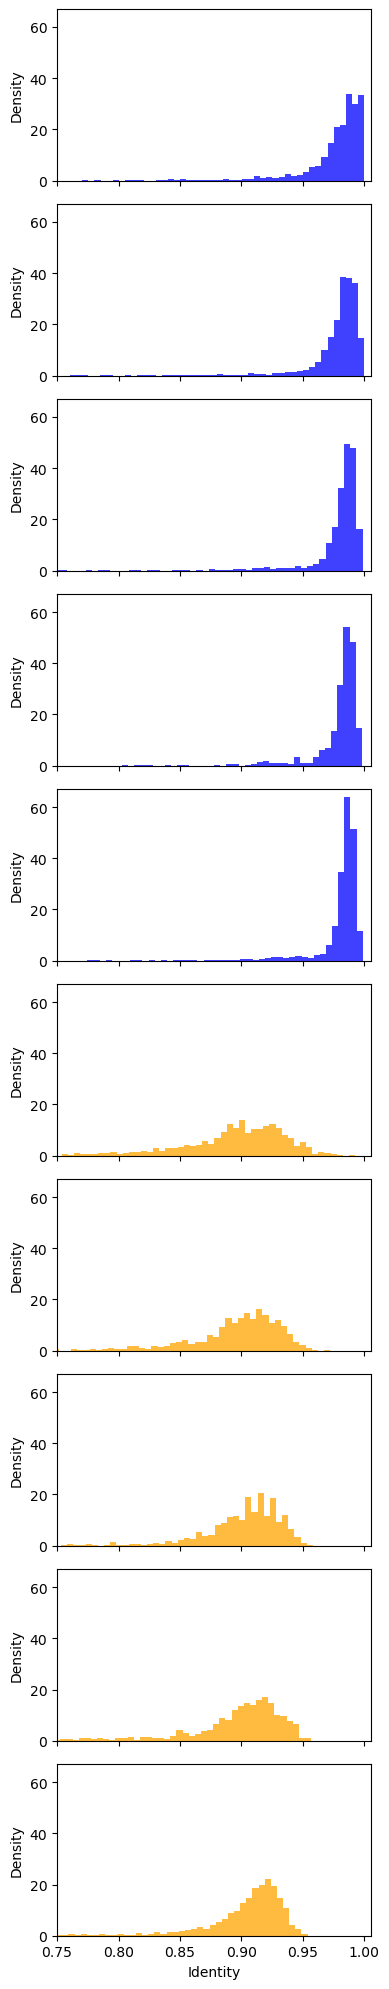

In [25]:
fig, ax = plt.subplots(10, sharex=True, sharey=True)
fig.set_figwidth(4)
fig.set_figheight(20)
ax[0].set_xlim([0.75, 1.005])
for i in range(5):
    sns.histplot(data=merged_df[(merged_df["chemistry"]=="004") & (merged_df["length_bin"] == i)], x = "Identity", binwidth = 0.005, stat="density", ax = ax[i], color = "blue", linewidth = 0)
    sns.histplot(data=merged_df[(merged_df["chemistry"]=="002") & (merged_df["length_bin"] == i)], x = "Identity", binwidth = 0.005, stat="density", ax = ax[i+5], color = "orange", linewidth = 0)
    ax[i].grid(False)
    ax[i+5].grid(False)
    
fig.tight_layout()
fig.get_figure().savefig(os.path.join(working_dir, "Split_length_vs_identity_Histplots_500.pdf"))